# Simple CNN

In [2]:
import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
import numpy as np
import nnabla.initializer as I

nn.parameter.clear_parameters()

rng = np.random.seed(31024)
initializer = I.UniformInitializer((-0.1, 0.1), rng=rng)

# create 16 random images 256x256 (RGB)
x = nn.Variable((16, 3, 256, 256))
x.d = np.random.random(x.shape)  # random input, just for example.

y0 = PF.convolution(x, outmaps=64, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv1", with_bias=False)
y1 = F.relu(y0)
y2 = PF.convolution(y1, outmaps=128, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv2", with_bias=False)
y3 = F.relu(y2)
y4 = F.average_pooling(y3, kernel=y3.shape[2:])
y5 = PF.affine(y4, 1, w_init=initializer)
loss = F.mean(F.abs(y5 - 1.))
loss.forward()  # Execute forward

# We can check the current gradient of parameter.
print("******* forward *******")
print(nn.get_parameters()["conv1/conv/W"].g)

loss.backward()
print("******* backward *******")
print(nn.get_parameters()["conv1/conv/W"].g)

2020-04-23 13:55:21,980 [nnabla][INFO]: Initializing CPU extension...
2020-04-23 13:55:23,088 [nnabla][INFO]: Calling the `.data` getter property in this `NdArray` is creating an array with a default data type because the array is not previously initialized by requesting a specific data type, or is not used after calling `zero()` or `fill(value)`.


******* forward *******
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 ...


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]
******* backward *******
[[[[ 0.0073202   0.00957133  0.01154457]
   [ 0.00971613  0.01164554  0.00966228]
   [ 0.01154376  0.00752073  0.00929334]]

  [[ 0.00930321 

## CNN with static graph
In this section, we demonstrate:
 - building a simple graph
 - training model
 - running prediction (with the trained model)
 - saving trained model
 - loading trained model
 - running prediction (with the loaded model)

In [14]:
import sys
import numpy as np
from sklearn.datasets import load_digits  # Only for dataset

import nnabla as nn
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solvers as S
import nnabla.initializer as I
from nnabla.monitor import tile_images
from nnabla.utils.data_iterator import data_iterator_simple

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nn.clear_parameters()
nn.reset_array_preference()

# set graph
CNN_GRAPH = 1

batch_size = 64
h5_file_name = 'static_graph.h5'
nnp_file_name = 'cnn_static_graph.nnp'
nnb_file_name = 'cnn_static_graph.nnb'
csrc_dir_name = 'cnn_static_graph_csrc'

rng = np.random.seed(31024)
initializer = I.UniformInitializer((-0.1, 0.1), rng=rng)

imshow_opt = dict(cmap='gray', interpolation='nearest')

In [15]:
imshow_opt = dict(cmap='gray', interpolation='nearest')

def plot_stats(digits):
    print("Num images:", digits.images.shape[0])
    print("Image shape:", digits.images.shape[1:])
    print("Labels:", digits.target[:10])
    plt.imshow(tile_images(digits.images[:64, None]), **imshow_opt)


def data_iterator_tiny_digits(digits, batch_size=batch_size, shuffle=False, rng=None):
    def load_func(index):
        """Loading an image and its label"""
        img = digits.images[index]
        label = digits.target[index]
        return img[None], np.array([label]).astype(np.int32)
    return data_iterator_simple(load_func, digits.target.shape[0], batch_size, shuffle, rng, with_file_cache=False)

Num images: 1797
Image shape: (8, 8)
Labels: [0 1 2 3 4 5 6 7 8 9]
type(digits) = <class 'sklearn.utils.Bunch'>


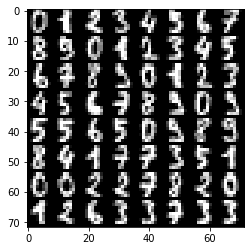

In [16]:
# get dataset
digits = load_digits(n_class=10)
plot_stats(digits)
print('type(digits) = %s' % type(digits))

2020-04-23 15:03:08,661 [nnabla][INFO]: DataSource with shuffle(True)
2020-04-23 15:03:08,663 [nnabla][INFO]: Using DataSourceWithMemoryCache
2020-04-23 15:03:08,663 [nnabla][INFO]: DataSource with shuffle(True)
2020-04-23 15:03:08,664 [nnabla][INFO]: On-memory
2020-04-23 15:03:08,664 [nnabla][INFO]: Using DataIterator


labels: [[5 9 7 4 5 7 0 8]
 [1 6 1 7 4 5 8 8]
 [3 3 1 7 1 6 7 9]
 [7 1 3 6 3 6 6 3]
 [7 8 0 1 5 5 4 6]
 [0 5 5 0 8 9 7 8]
 [3 9 8 5 9 7 4 6]
 [8 2 7 6 7 2 3 6]]
Label shape: (64, 1)
type(img) = <class 'numpy.ndarray'>, img.shape = (64, 1, 8, 8)
type(label) = <class 'numpy.ndarray'>
[[[ 0.  0.  5. 12. 16.  9.  0.  0.]
  [ 0.  7. 16. 10.  3.  0.  0.  0.]
  [ 0.  8. 13.  0.  0.  0.  0.  0.]
  [ 0.  9. 14.  4.  6.  0.  0.  0.]
  [ 0.  4. 14. 12. 13. 13.  1.  0.]
  [ 0.  0.  0.  0.  0. 15.  4.  0.]
  [ 0.  0.  0.  0.  4. 15.  7.  0.]
  [ 0.  0.  4. 12. 13.  8.  0.  0.]]]


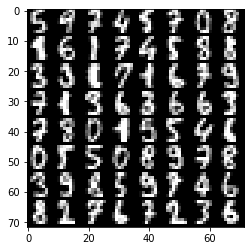

In [17]:
data = data_iterator_tiny_digits(digits, batch_size=batch_size, shuffle=True)
img, label = data.next()
plt.imshow(tile_images(img), **imshow_opt)
print("labels:", label.reshape(8, 8))
print("Label shape:", label.shape)
print('type(img) = %s, img.shape = %s' % (type(img), img.shape))
print('type(label) = %s' % type(label))

print(img[0])

### build a graph
> Note: we have to run only one section:
    - build simple graph
    - build more complex graph

#### build simple graph

In [18]:
if CNN_GRAPH == 0:
    # Forward pass
    x = nn.Variable(img.shape)  # Define an image variable
    with nn.parameter_scope("affine1"):
        y = PF.affine(x, 10)  # Output is 10 class

    # Building a loss graph
    t = nn.Variable(label.shape)  # Define an target variable
    loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems

    print("Printing shapes of variables")
    print('x:', x.shape)
    print('y:', y.shape)
    print('t:', t.shape)
    print('loss:', loss.shape)  # empty tuple means scalar

#### build more complex graph

In [19]:
if CNN_GRAPH == 1:
    # Forward pass
    x = nn.Variable(img.shape)  # Define an image variable
    with nn.parameter_scope("affine1"):
        y0 = PF.convolution(x, outmaps=batch_size, kernel=(3, 3), pad=(1, 1), stride=(2, 2), w_init=initializer, name="conv1", with_bias=False)
        y1 = F.relu(y0)
        # since the image is already too small, pooling does not make sense
        # y2 = F.max_pooling(y1, kernel=y1.shape[2:])
        y = PF.affine(y1, 10)  # Output is 10 class

    # Building a loss graph
    t = nn.Variable(label.shape)  # Define an target variable
    loss = F.mean(F.softmax_cross_entropy(y, t))  # Softmax Xentropy fits multi-class classification problems

    print("Printing shapes of variables")
    print('x:', x.shape)
    print('y0:', y0.shape)
    print('y1:', y1.shape)
    print('y:', y.shape)
    print('t:', t.shape)
    print('loss:', loss.shape)  # empty tuple means scalar

Printing shapes of variables
x: (64, 1, 8, 8)
y0: (64, 64, 4, 4)
y1: (64, 64, 4, 4)
y: (64, 10)
t: (64, 1)
loss: ()


### Stochastic Gradient Solver

In [20]:
# Create a solver (gradient-based optimizer)
learning_rate = 1e-3
solver = S.Sgd(learning_rate)
solver.set_parameters(nn.get_parameters())  # Set parameter variables to be updated.

### training

In [21]:
# Training
n_epochs = 1000
total_epochs = 0

In [22]:
for _ in range(n_epochs):
    x.d, t.d = data.next()
    loss.forward()
    solver.zero_grad()  # Initialize gradients of all parameters to zero.
    loss.backward()
    solver.weight_decay(1e-5)  # Applying weight decay as an regularization
    solver.update()
    total_epochs = total_epochs + 1
    if total_epochs % 100 == 0:  # Print for each 10 iterations
        print('epoch=%d loss=%f' % (total_epochs, loss.d))

epoch=100 loss=1.398087
epoch=200 loss=0.851872
epoch=300 loss=0.569510
epoch=400 loss=0.574728
epoch=500 loss=0.361557
epoch=600 loss=0.331541
epoch=700 loss=0.351856
epoch=800 loss=0.317157
epoch=900 loss=0.342510
epoch=1000 loss=0.125865


prediction:
[[8 9 5 0 5 0 3 0]
 [2 1 7 5 5 2 4 5]
 [3 1 5 1 6 8 7 3]
 [5 0 5 9 9 1 0 1]
 [0 6 8 1 6 6 5 9]
 [4 5 3 9 1 6 3 0]
 [0 8 6 2 1 7 2 6]
 [4 4 6 4 8 8 3 7]]


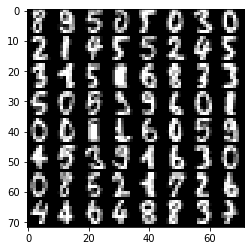

In [23]:
# prediction
x.d, t.d = data.next()  # Here we predict images from training set although it's useless. 
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

### save model

In [24]:
def save_nnp(input, output, batchsize):
    runtime_contents = {
        'networks': [
            {'name': 'Validation',
             'batch_size': batchsize,
             'outputs': output,
             'names': input}],
        'executors': [
            {'name': 'Runtime',
             'network': 'Validation',
             'data': [k for k, _ in input.items()],
             'output':[k for k, _ in output.items()]}]}
    return runtime_contents

In [25]:
# save parameters
nn.save_parameters(h5_file_name)

2020-04-23 15:03:12,346 [nnabla][INFO]: Parameter save (.h5): static_graph.h5


In [26]:
img = nn.Variable(x.shape)
lab = nn.Variable(t.shape)
img.d, lab.d = data.next()
if CNN_GRAPH == 0:
    content = save_nnp(input={'x': x}, output={'y': y, 'loss': loss, 't': t}, batchsize=batch_size)
elif CNN_GRAPH == 1:
    # content = save_nnp(input={'x': x}, output={'y': y, 'y0': y0, 'y1': y1, 'loss': loss, 't': t}, batchsize=batch_size)
    content = save_nnp(input={'x': x}, output={'y': y, 'y0': y0, 'y1': y1}, batchsize=batch_size)
print(content)

{'networks': [{'name': 'Validation', 'batch_size': 64, 'outputs': {'y': <Variable((64, 10), need_grad=True) at 0x7ff06e50a9b0>, 'y0': <Variable((64, 64, 4, 4), need_grad=True) at 0x7ff06e50a890>, 'y1': <Variable((64, 64, 4, 4), need_grad=True) at 0x7ff06e50a650>}, 'names': {'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7ff06e547650>}}], 'executors': [{'name': 'Runtime', 'network': 'Validation', 'data': ['x'], 'output': ['y', 'y0', 'y1']}]}


In [27]:
import nnabla.utils.save as save
save.save(nnp_file_name, content)

2020-04-23 15:03:12,934 [nnabla][INFO]: Saving cnn_static_graph.nnp as nnp
2020-04-23 15:03:12,936 [nnabla][INFO]: Saving /tmp/tmp1vfoockr/network.nntxt as prototxt
2020-04-23 15:03:12,948 [nnabla][INFO]: Parameter save (.protobuf): /tmp/tmp1vfoockr/parameter.protobuf


### load model

In [28]:
from nnabla.utils.nnp_graph import NnpLoader

# load h5
nn.load_parameters(h5_file_name)
# Read a .nnp file.
nnp = NnpLoader(nnp_file_name)

In [29]:
nw_name = nnp.get_network_names()[0]
net = nnp.get_network(nw_name)

In [30]:
net.variables

{'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7ff06e3f9830>,
 'affine1/conv1/conv/W': <Variable((64, 1, 3, 3), need_grad=True) at 0x7ff06e3f98f0>,
 'y0': <Variable((64, 64, 4, 4), need_grad=True) at 0x7ff06e3f99b0>,
 'y1': <Variable((64, 64, 4, 4), need_grad=True) at 0x7ff06e3f91d0>,
 'affine1/affine/W': <Variable((1024, 10), need_grad=True) at 0x7ff06e3f9290>,
 'affine1/affine/b': <Variable((10,), need_grad=True) at 0x7ff06e3f9230>,
 'y': <Variable((64, 10), need_grad=True) at 0x7ff06e3fd830>}

In [31]:
nw_name = nnp.get_network_names()[0]
print('nw_name = %s' % nw_name)
net = nnp.get_network(nw_name)
print(net)
# load h5
nn.load_parameters(h5_file_name)

nw_name = Validation


In [32]:
print(net.inputs)
print(net.outputs)

{'x': <Variable((64, 1, 8, 8), need_grad=False) at 0x7ff06e3f9ad0>}
{'y': <Variable((64, 10), need_grad=True) at 0x7ff06e3f9d70>}


In [33]:
x = net.inputs['x']
y = net.outputs['y']
print(x)
print(y)

<Variable((64, 1, 8, 8), need_grad=False) at 0x7ff06e3f9ad0>
<Variable((64, 10), need_grad=True) at 0x7ff06e3f9d70>


data.position=1361
prediction:
[[0 2 3 7 7 0 3 0]
 [9 2 0 4 0 3 2 4]
 [7 8 5 6 8 7 5 4]
 [8 7 8 8 6 4 2 5]
 [1 0 5 7 6 3 3 8]
 [1 8 7 0 2 1 9 5]
 [5 1 3 7 9 8 6 6]
 [2 5 1 6 2 6 5 0]]


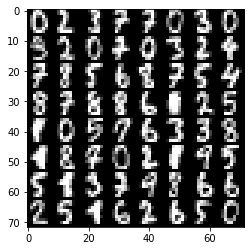

In [34]:
# prediction
print('data.position=%d' % data.position)
x.d, _ = data.next()  # Here we predict images from training set although it's useless. 
y.forward()  # You can execute a sub graph.
plt.imshow(tile_images(x.d), **imshow_opt)
print("prediction:")
print(y.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

### File format conversion

#### Convert from NNP to NNB

In [35]:
# Convert from NNP to NNB
import subprocess, sys, os
out = subprocess.Popen(['nnabla_cli', 'convert', '-b', '%d' % batch_size, nnp_file_name, nnb_file_name])
assert(os.path.exists(nnb_file_name))
assert(os.path.isfile(nnb_file_name))

#### Convert from NNP to C source
This generated C source files are in the directory `csrc_dir_name`, with a GNUmakefile. This should be a good example of using the generated C source model.

Requirements before compiling the C source:
1. clone the official Nnabla C Runtime from https://github.com/sony/nnabla-c-runtime (without -fPIE flag) or https://github.com/mu-triv/nnabla-c-runtime (with -fPIE)
2. compile Nnabla C Runtime (`make`)
3. set these environment variables:
    * `LD_LIBRARY_PATH` and `LIBRARY_PATH` (example: `nnabla-c-runtime/build/_CPack_Packages/Linux/ZIP/nnabla-c-runtime-1.2.0.dev1_c1-Linux/lib`)
    * `C_INCLUDE_PATH` and `CPLUS_INCLUDE_PATH` (example: `nnabla-c-runtime/include`)
    * Or you will need to modify the GNUmakefile

The generated C source is compiled with the following command:
```
cd csrc_dir_name
make
```

In [36]:
# Convert from NNP to CSRC
import subprocess
import pathlib
pathlib.Path(csrc_dir_name).mkdir(parents=True, exist_ok=True) 

out = subprocess.Popen(['nnabla_cli', 'convert', '-b', '%d' % batch_size, '-O', 'CSRC', nnp_file_name, csrc_dir_name])
assert(os.path.exists(nnb_file_name))
assert(os.path.isdir(csrc_dir_name))

#### save 64 raw images
These images are used with prediction later

In [40]:
prediction_file = 'img_64010808.raw'

data.position=1425
x.d.shape = (64, 1, 8, 8)
type = <class 'numpy.float64'>


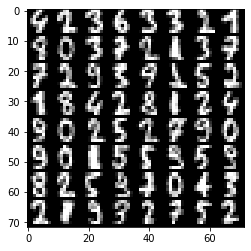

In [38]:
with open(prediction_file, 'wb') as fh:
    print('data.position=%d' % data.position)
    x.d, _ = data.next()
    print('x.d.shape = %s' % str(x.d.shape))
    print('type = %s' % type(x.d[0,0,0,0]))
    fh.write(np.float32(x.d))
plt.imshow(tile_images(x.d), **imshow_opt)

### display the prediction results
> Note: execute this cell after the CSRC inference execution

This cell displays the prediction result and allows to compare the result with the reference images.

I assume that we execute the CSCR inference this way

`./Validation_example ../img_64010808.raw output`

> `img_64010808.raw` is defined in `prediction_file`
>
> `output` is the header of the output file names

After executing the prediction in CSRC, we obtain several output data, such as `output_0.bin`, `output_1.bin`, `output_2.bin`

[[4 2 3 6 3 3 2 9]
 [1 0 3 7 2 1 3 7]
 [7 2 9 5 9 1 5 2]
 [1 8 4 2 8 1 2 4]
 [9 0 2 5 2 7 9 0]
 [9 0 1 5 5 9 5 9]
 [8 2 5 9 7 0 4 3]
 [2 7 9 7 2 7 5 2]]


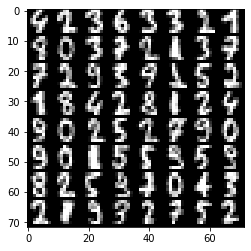

In [41]:
import os
yinf = nn.Variable(y.shape)
prediction_result_file = os.path.join(csrc_dir_name, 'output_0.bin')
with open(prediction_result_file, 'rb') as fh:
    fbytes = fh.read()

afloats = np.frombuffer(fbytes, dtype=np.float32)
yinf.d = np.reshape(afloats, yinf.shape)
print(yinf.d.argmax(axis=1).reshape(8, 8))  # Taking a class index based on prediction score.

# load the reference images
yref = nn.Variable(x.shape)
with open(prediction_file, 'rb') as fh:
    yref_d = fh.read()
yref.d = np.reshape(np.frombuffer(yref_d, dtype=np.float32), yref.shape)
# display the reference images
plt.imshow(tile_images(yref.d), **imshow_opt)

# Annex

## Functions

In [ ]:
import numpy as np
x=3; y=4; z=5
a = np.random.randint(0, 10, size=(x,y,z))
b = np.random.randint(0, 10, size=(x,y,z))

### compare constants

In [ ]:
import nnabla as nn

nn.set_auto_forward(True)

x0 = nn.NdArray((a.shape))
x0.data = a
x1 = nn.NdArray((b.shape))
x1.data = b
print("x0=", x0.data)
print("x1=", x1.data)

In [ ]:
r = nn.functions.equal(x0, x1, n_outputs=-1, outputs=None)
print(r, r.data)

In [ ]:
r = nn.functions.greater(x0, x1, n_outputs=-1, outputs=None)
print(r, r.data)

### compare variables

In [ ]:
x2 = nn.Variable(x0.shape)
x2.data = x0
x3 = nn.Variable(x1.shape)
x3.data = x1

In [ ]:
r = nn.functions.greater(x2, x3, n_outputs=-1, outputs=None)
print(r, r.d)

## minimum

In [ ]:
import nnabla.functions as F

x = nn.Variable.from_numpy_array(np.random.rand(2, 3, 4))
print(x)
print(x.d)

minval = F.min(x, axis=1)
print(minval)
print(minval.d)

## function relu

In [ ]:
import nnabla.parametric_functions as PF
import nnabla.functions as F

x = nn.Variable((2, 3, 8, 8))
x.d = np.random.random(x.shape)  # random input, just for example.

nn.parameter.clear_parameters()
with nn.parameter_scope('conv1') as param:
    conv_out = PF.convolution(x, 2, (5, 5))
    relu_out = F.relu(conv_out)
    
print(relu_out)
print(relu_out.d)

## sigmoid

In [ ]:

import nnabla.parametric_functions as PF
import nnabla.functions as F

x = nn.Variable((2, 3, 8, 8))
x.d = np.random.random(x.shape)  # random input, just for example.

nn.parameter.clear_parameters()
with nn.parameter_scope('conv2') as param:
    conv_out = PF.convolution(x, 2, (5, 5))
    sig_out = F.sigmoid(conv_out)
    
print(sig_out)
print(sig_out.d)

## Parametric functions

## Affine

In [ ]:
import numpy as np
import nnabla as nn
import nnabla.parametric_functions as PF

x = nn.Variable.from_numpy_array(np.array([[1, 2], [3, 4]]))
y = PF.affine(x, 4, name="y")
print("x")
print(x.d)
print("y")
print(y.d)